## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

In [2]:
# specify if you want to add high-resolution P1D (only working for Pedersen23 emulator)
add_hires=False
if add_hires:
    kmax_Mpc=8
else:
    kmax_Mpc=4

### Setup emulator

The emulator will be used both to make a mock, and in the likelihood 

In [3]:
#emulator=nn_emulator.NNEmulator(training_set='Nyx23',emulator_label='Cabayol23_Nyx')
emulator=nn_emulator.NNEmulator(training_set='Cabayol23',emulator_label='Cabayol23')
#emulator=gp_emulator.GPEmulator(training_set='Pedersen21',kmax_Mpc=kmax_Mpc)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


### Create mock P1D data

Use Lya theory to mimic mock data

In [4]:
data=mock_data.Mock_P1D(emulator=emulator,data_label="Chabanier2019")

In [5]:
# check if we also need mock extra_p1d
if add_hires:
    extra_data=mock_data.Mock_P1D(emulator=emulator,data_label="Karacayli2022")
else:
    extra_data=None

### Set free parameters and theory

In [6]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [7]:
theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)

In [8]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 1e-09 , 3.2e-09
ns = 0.965 , 0.88 , 1.05
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_kF_1 = 0.0 , -0.4 , 0.4


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [9]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4
chi2 = -0.0


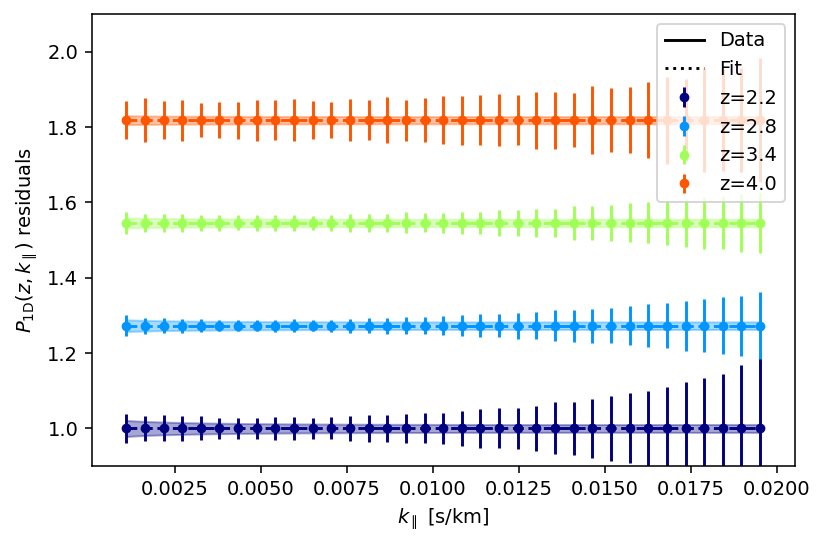

In [10]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))
print('chi2 =',like.get_chi2(values=test_values))
like.plot_p1d(values=test_values,residuals=True,plot_every_iz=3)

In [11]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=3)

### Run iminuit minimizer

In [12]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.02
ini_values=2*ini_sigma*np.random.random(len(like.free_params))+0.5-ini_sigma
print('ini values',ini_values)
for p in like.parameters_from_sampling_point(values=ini_values):
    print(p.info_str(all_info=True))

ini values [0.4911393  0.48004609 0.51420826 0.49455762 0.50074501 0.48853316
 0.48232874 0.49805795 0.51708613 0.51536635]
As = 2.0805064570555053e-09 , 1e-09 , 3.2e-09
ns = 0.9616078348372287 , 0.88 , 1.05
ln_tau_0 = 0.002841652391066596 , -0.1 , 0.1
ln_sigT_kms_0 = -0.0043539070919561 , -0.4 , 0.4
ln_gamma_0 = 0.00029800400125196136 , -0.2 , 0.2
ln_kF_0 = -0.00458673480859878 , -0.2 , 0.2
ln_tau_1 = -0.007068502595870774 , -0.2 , 0.2
ln_sigT_kms_1 = -0.001553641671203032 , -0.4 , 0.4
ln_gamma_1 = 0.013668907254153873 , -0.4 , 0.4
ln_kF_1 = 0.012293080979175142 , -0.4 , 0.4


In [13]:
minimizer = iminuit_minimizer.IminuitMinimizer(like,ini_values=ini_values)

In [14]:
minimizer.minimize(compute_hesse=True)

In [15]:
# what is the chi2 of the best-fit? (should be close to 0)
best_fit_values=np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

0.0020300485427420917

In [16]:
# what was the chi2 of the starting point?
like.get_chi2(values=ini_values)

2.96137289264441

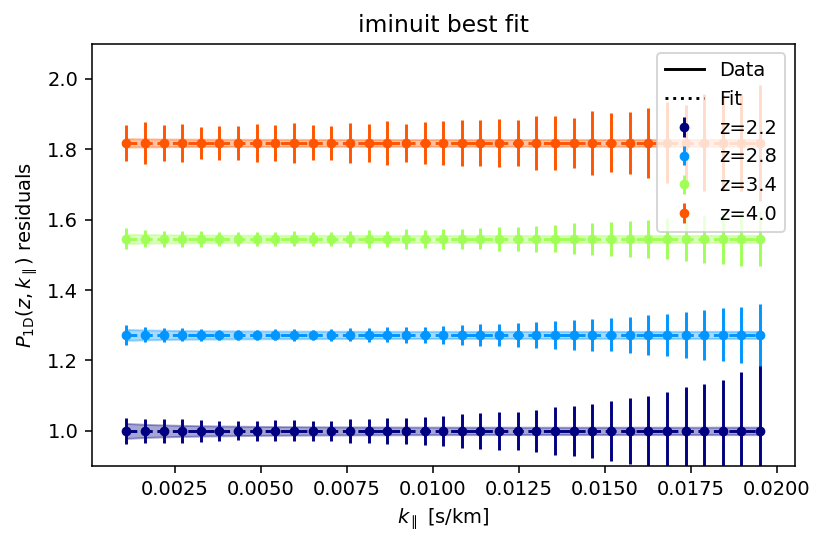

In [17]:
minimizer.plot_best_fit(plot_every_iz=3)

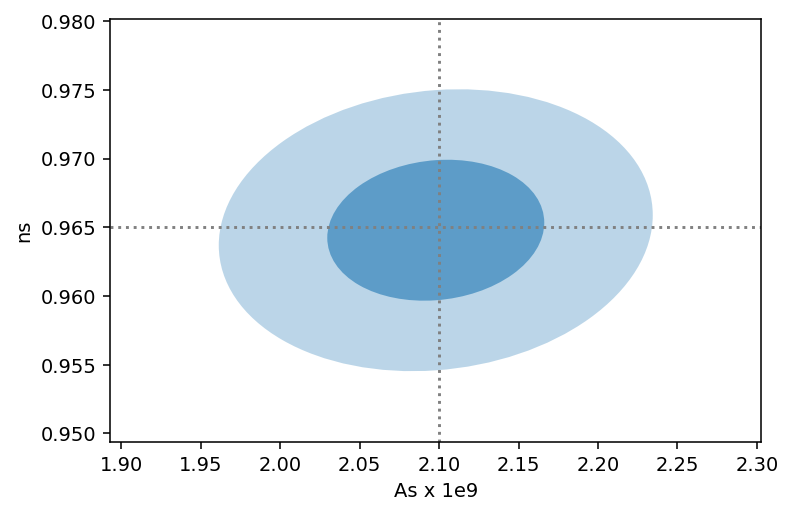

In [18]:
minimizer.plot_ellipses('As','ns')

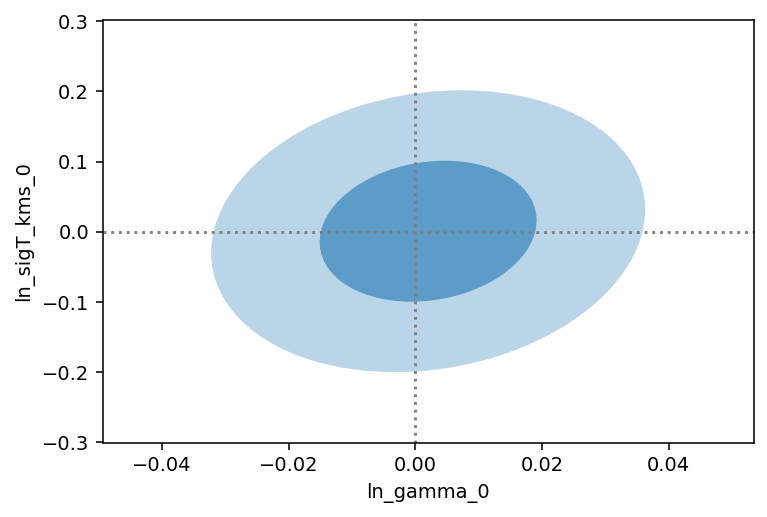

In [19]:
minimizer.plot_ellipses('ln_gamma_0','ln_sigT_kms_0')

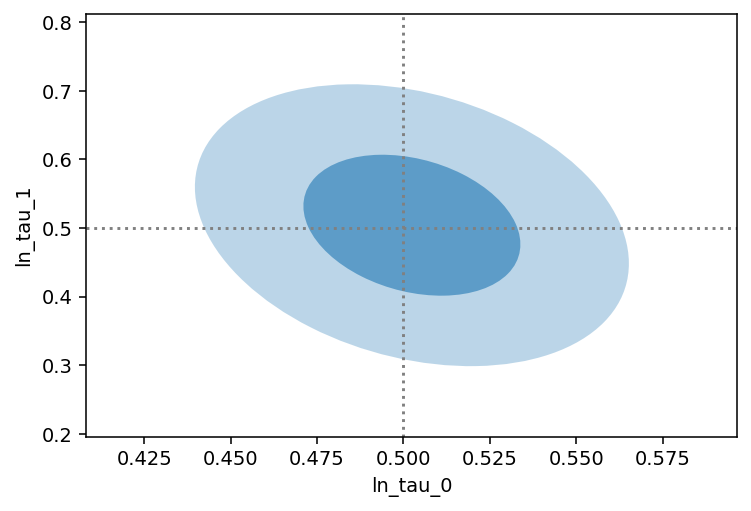

In [20]:
minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [21]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 153.5                      │              Nfcn = 888              │
│ EDM = 1.46e-05 (Goal: 0.0001)    │           time = 45.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.50    │   0.04    │            │            │         │         │       │
│ 1 │ x1   │   0.50    │   0.14    │            │            │         │         │       │
│ 2 │ x2   │   0.50    │   0.06    │            │            │         │         │       │
│ 3 │ x3   │   0.50    │   0.04    │            │            │         │         │       │
│ 4 │ x4   │   0.50    │   0.07    │            │            │         │         │       │
│ 5 │ x5   │    0.5    │    0.4    │            │            │         │         │       │
│ 6 │ x6   │   0.50    │   0.16    │            │            │         │         │       │
│ 7 │ x7   │   0.50    │   0.27    │            │            │         │         │       │
│ 8 │ x8   │   0.51    │   0.24    │            │            │         │         │       │
│ 9 │ x9   │    0.5    │    0.4    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │   0.00144  -0.00194  -0.00146 -0.000612 -0.000471   0.00584  0.000427   0.00353   0.00198  -0.00436 │
│ x1 │  -0.00194    0.0198  -0.00168  0.000698  -0.00302   -0.0549  -0.00213   -0.0142   -0.0105    0.0418 │
│ x2 │  -0.00146  -0.00168   0.00404 -0.000509   0.00322   0.00288  0.000707  -0.00221  0.000587 -0.000947 │
│ x3 │ -0.000612  0.000698 -0.000509   0.00186 -0.000348  -0.00254 -0.000862  -0.00376  -0.00136  0.000131 │
│ x4 │ -0.000471  -0.00302   0.00322 -0.000348   0.00535   0.00883  0.000531  -0.00146   0.00337   -0.0117 │
│ x5 │   0.00584   -0.0549   0.00288  -0.00254   0.00883     0.164   0.00407    0.0453     0.029    -0.139 │
│ x6 │  0.000427  -0.00213  0.000707 -0.000862  0.000531   0.00407    0.0245   -0.0276    0.0321    0.0011 │
│ x7 │   0.00353   -0.0142  -0.00221  -0.00376  -0.00146    0.0453   -0.0276    0.0703   -0.0257    -0.048 │
│ x8 │   0.00198   -0.0105  0.000587  -0.00136   0.00337     0.029    0.0321   -0.0257    0.0578   -0.0265 │
│ x9 │  -0.00436    0.0418 -0.000947  0.000131   -0.0117    -0.139    0.0011    -0.048   -0.0265     0.184 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [22]:
minimizer.minimizer.errors

<ErrorView x0=0.03795751383087198 x1=0.14056792773824847 x2=0.06354113925782338 x3=0.043083794150769864 x4=0.07314516266786461 x5=0.4051552803917114 x6=0.1566660325937752 x7=0.26509466605078913 x8=0.24040297974507147 x9=0.42864617896497303>

In [23]:
minimizer.best_fit_value('ln_tau_0',return_hesse=True)

(0.0004991877859640698, 0.012708227851564677)